# Speech Enhancement

<div class="alert alert-info">

This tutorial is available as an IPython notebook at [malaya-speech/example/speech-enhancement](https://github.com/huseinzol05/malaya-speech/tree/master/example/speech-enhancement).
    
</div>

<div class="alert alert-warning">

This is an application of malaya-speech Pipeline, read more about malaya-speech Pipeline at [malaya-speech/example/pipeline](https://github.com/huseinzol05/malaya-speech/tree/master/example/pipeline).
    
</div>

In [1]:
import malaya_speech
import numpy as np
from malaya_speech import Pipeline

In [2]:
y, sr = malaya_speech.load('speech/khutbah/wadi-annuar.wav')
len(y), sr

(160000, 16000)

In [3]:
import IPython.display as ipd
ipd.Audio(y, rate = sr)

The speech got room echo and a bit of broken high pitch, because it recorded in mosque and maybe no limit high shelf.

### List available deep model

In [4]:
malaya_speech.speech_enhancement.available_model()

,Size (MB),MSE
resnet34-unet,97.8,0.0003
inception-v3-unet,120.0,0.0003


### Load deep model

Deep model trained on different augmented pitch, augmented room echo, augmented reverberance, augmented stereo depth.

In [5]:
model = malaya_speech.speech_enhancement.deep_model(model = 'resnet34-unet')

### How to enhance speech

`resnet34-unet` and `inception-v3-unet` trained on 1200 ms frames. So, we need to split our sample into smaller chunk of samples.

For speech enhancement, we need to use `malaya_speech.generator.mel_sampling`.

In [6]:
%%time

frames = malaya_speech.generator.mel_sampling(y)
len(frames)

CPU times: user 37 µs, sys: 2 µs, total: 39 µs
Wall time: 42 µs


10

In [7]:
%%time

mels = model(frames)

CPU times: user 6.17 s, sys: 801 ms, total: 6.97 s
Wall time: 1.73 s


`resnet34-unet` and `inception-v3-unet` will returned melspectrogram. So to change from melspectrogram into waveform, we need to use `malaya_speech.utils.griffin_lim.from_mel`,

```python
def from_mel(mel_):
    """
    Change melspectrogram into waveform using Librosa.

    Parameters
    ----------
    spectrogram: np.array

    Returns
    --------
    result: np.array
    """
```

In [8]:
mel = [malaya_speech.utils.griffin_lim.from_mel(mel) for mel in mels]
mel = malaya_speech.generator.combine_mel_sampling(mel, padded_ms = 1)
ipd.Audio(np.concatenate(mel), rate = sr)

In [9]:
%%time

frames = malaya_speech.generator.mel_sampling(y)
mels = model(frames)
mel = [malaya_speech.utils.griffin_lim.from_mel(mel) for mel in mels]
mel = malaya_speech.generator.combine_mel_sampling(mel)

CPU times: user 39.4 s, sys: 6.68 s, total: 46.1 s
Wall time: 9.57 s


`malaya_speech.utils.griffin_lim.from_mel` is quite expensive actually, **to speedup, you can do pipeline batching to utilize parallel processing**.

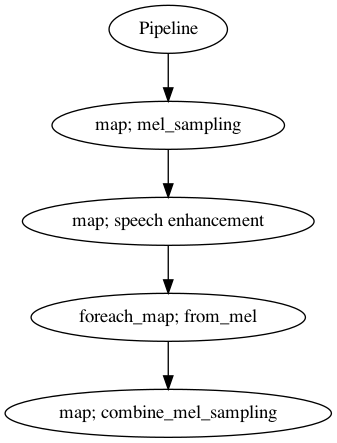

In [10]:
p = Pipeline()
pipeline = (
    p.map(malaya_speech.generator.mel_sampling)
    .map(model)
    .foreach_map(malaya_speech.utils.griffin_lim.from_mel, method = 'process', worker_size = 3)
    .map(malaya_speech.generator.combine_mel_sampling)
)
p.visualize()

In [11]:
%%time

result = p.emit(y)

CPU times: user 5.33 s, sys: 549 ms, total: 5.88 s
Wall time: 9.66 s


In [12]:
result.keys()

dict_keys(['mel_sampling', 'speech-enhancement', 'from_mel', 'combine_mel_sampling'])

In [13]:
ipd.Audio(np.concatenate(result['combine_mel_sampling']), rate = sr)